# CNN + MaxPool
Same as CNN_264 which achieved about 60% accuracy on all cell lines except H1.hESC. 

Here, increase K from 4 to 2.

In [13]:
from datetime import datetime
print(datetime.now())

2023-03-26 20:16:18.928248


In [14]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Found GPU at: /device:GPU:0
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [15]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=2
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=8 # 20 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
NUM_CELL_LINES=15
EXCLUSIONS = [1]   # exclude H1.hESC
print('Exclusions:',EXCLUSIONS)

Python 3.9.16
sklearn 1.2.2
Exclusions: [1]


In [16]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [17]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [18]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

## Model

In [19]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool1_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    drop1_layer = Dropout(0.5)
    cnn2_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool2_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    drop2_layer = Dropout(0.5)
    flat_layer = Flatten()
    #dens_layer = Dense(DCELLS,activation='relu')
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool1_layer)
    cnn.add(drop1_layer)
    cnn.add(cnn2_layer)
    cnn.add(pool2_layer)
    cnn.add(drop2_layer)
    cnn.add(flat_layer)
    cnn.add(output_layer)

    # Logits=False because sigmoid output is a probability in range [0.,1.]; see
    # https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class
    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return cnn

In [20]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-26 20:16:19.990574
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 4999, 4)           68        
                                                                 
 conv1d_22 (Conv1D)          (None, 4992, 64)          2112      
                                                                 
 max_pooling1d_22 (MaxPoolin  (None, 1247, 64)         0         
 g1D)                                                            
                                                                 
 dropout_22 (Dropout)        (None, 1247, 64)          0         
                                                                 
 conv1d_23 (Conv1D)          (None, 1240, 64)          32832     
                                                                 
 max_pooling1d_23 (MaxPoolin  (None, 309, 64)          0         
 g1D)                     

## Training

In [21]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [22]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            if gene_id in self.val_genes:
                self.val_ids.append(allids[t])
                self.val_seq.append(allseq[t])
                self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                self.train_ids.append(allids[t])
                self.train_seq.append(allseq[t])
                self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-26 20:16:20.229239
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-03-26 20:16:26.727384

Training # 1 1
2023-03-26 20:16:26.729148
2023-03-26 20:16:26.729552
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Computed class weights: {0: 1.029723366686286, 1: 0.9719444444444445}
Valid 1:0 458:412 52.64%
FIT
2023-03-26 20:16:29.139530


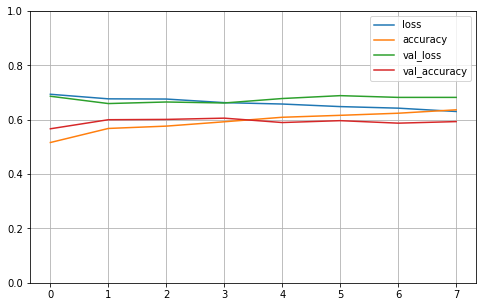


2023-03-26 20:16:51.141925

Testing # 1 1
2023-03-26 20:16:51.142037
2023-03-26 20:16:51.142073
PREDICT
2023-03-26 20:16:51.373118
Test 1:0 458:412 52.64%
Predict 1:0 420:450 48.28%
Test sizes (870, 4999) (870,)
Range of scores: 0.06266812 to 0.94041795
Score threshold 0.5
Confusion matrix
 [[254 158]
 [196 262]]
Normalized matrix
 [[0.29195402 0.1816092 ]
 [0.22528736 0.30114943]]


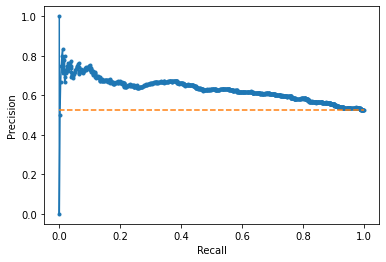

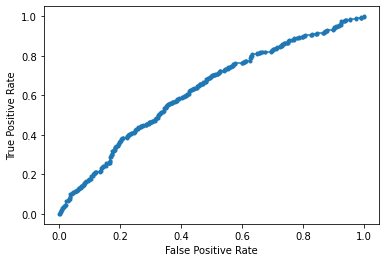

Accuracy: 59.31% Precision: 62.38% Recall: 57.21%
F1: 59.68% MCC: 0.1884
AUPRC: 62.99% AUROC: 62.51%
 accuracy [59.310344827586206]
 precision [62.38095238095238]
 recall [57.20524017467249]
 F1 [59.68109339407744]
 MCC [0.18840555115721044]
 AUPRC [62.99108228579728]
 AUROC [62.50529952940178]
2023-03-26 20:16:52.189057

Training # 1 2
2023-03-26 20:16:52.189212
2023-03-26 20:16:52.189256
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Computed class weights: {0: 1.0440383463151588, 1: 0.9595264317180616}
Valid 1:0 442:442 50.00%
FIT
2023-03-26 20:16:53.765555


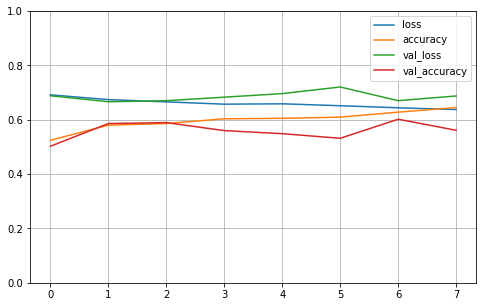


2023-03-26 20:17:16.092971

Testing # 1 2
2023-03-26 20:17:16.093408
2023-03-26 20:17:16.093442
PREDICT
2023-03-26 20:17:16.338898
Test 1:0 442:442 50.00%
Predict 1:0 638:246 72.17%
Test sizes (884, 4999) (884,)
Range of scores: 0.061131127 to 0.9005601
Score threshold 0.5
Confusion matrix
 [[150 292]
 [ 96 346]]
Normalized matrix
 [[0.16968326 0.33031674]
 [0.10859729 0.39140271]]


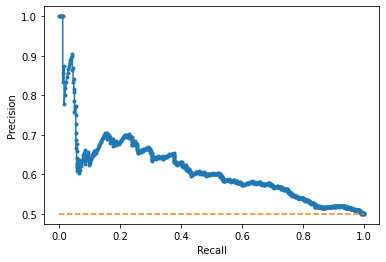

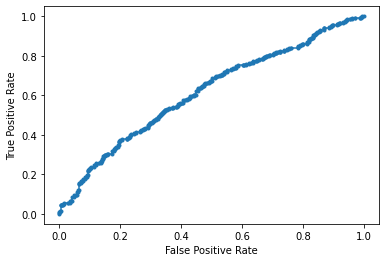

Accuracy: 56.11% Precision: 54.23% Recall: 78.28%
F1: 64.07% MCC: 0.1363
AUPRC: 61.27% AUROC: 61.58%
 accuracy [56.10859728506787]
 precision [54.2319749216301]
 recall [78.28054298642535]
 F1 [64.07407407407408]
 MCC [0.13630628046778104]
 AUPRC [61.26695263133548]
 AUROC [61.58350566122724]
2023-03-26 20:17:17.183448

Training # 1 3
2023-03-26 20:17:17.184227
2023-03-26 20:17:17.184284
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Computed class weights: {0: 1.0328638497652582, 1: 0.9691629955947136}
Valid 1:0 442:407 52.06%
FIT
2023-03-26 20:17:18.444104


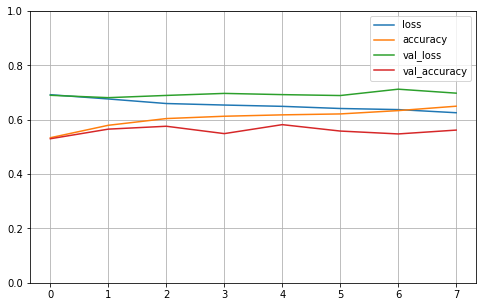


2023-03-26 20:17:40.973996

Testing # 1 3
2023-03-26 20:17:40.974111
2023-03-26 20:17:40.974148
PREDICT
2023-03-26 20:17:41.196002
Test 1:0 442:407 52.06%
Predict 1:0 496:353 58.42%
Test sizes (849, 4999) (849,)
Range of scores: 0.03225795 to 0.9227699
Score threshold 0.5
Confusion matrix
 [[194 213]
 [159 283]]
Normalized matrix
 [[0.22850412 0.25088339]
 [0.18727915 0.33333333]]


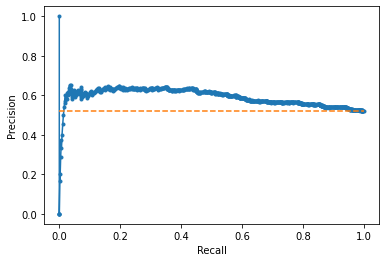

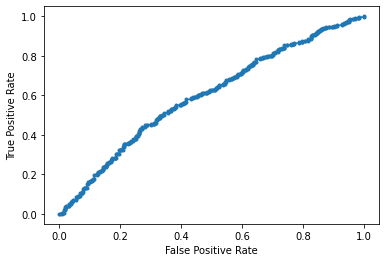

Accuracy: 56.18% Precision: 57.06% Recall: 64.03%
F1: 60.34% MCC: 0.1185
AUPRC: 59.07% AUROC: 59.78%
 accuracy [56.18374558303887]
 precision [57.056451612903224]
 recall [64.02714932126696]
 F1 [60.3411513859275]
 MCC [0.11852391439056162]
 AUPRC [59.065551676328184]
 AUROC [59.78492890257596]
2023-03-26 20:17:42.016767

Training # 1 4
2023-03-26 20:17:42.018100
2023-03-26 20:17:42.018154
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Computed class weights: {0: 1.0354166666666667, 1: 0.9669260700389105}
Valid 1:0 459:431 51.57%
FIT
2023-03-26 20:17:43.259430


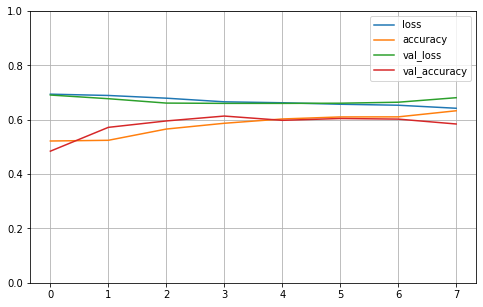


2023-03-26 20:17:57.710038

Testing # 1 4
2023-03-26 20:17:57.710124
2023-03-26 20:17:57.710158
PREDICT
2023-03-26 20:17:57.969422
Test 1:0 459:431 51.57%
Predict 1:0 721:169 81.01%
Test sizes (890, 4999) (890,)
Range of scores: 0.20198122 to 0.93700767
Score threshold 0.5
Confusion matrix
 [[115 316]
 [ 54 405]]
Normalized matrix
 [[0.12921348 0.35505618]
 [0.06067416 0.45505618]]


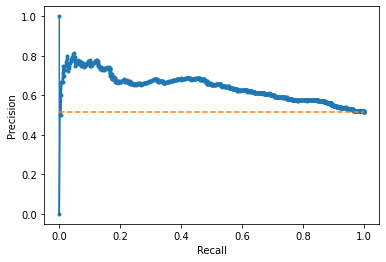

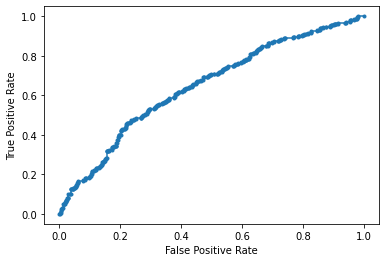

Accuracy: 58.43% Precision: 56.17% Recall: 88.24%
F1: 68.64% MCC: 0.1901
AUPRC: 64.25% AUROC: 64.71%
 accuracy [58.42696629213483]
 precision [56.171983356449374]
 recall [88.23529411764706]
 F1 [68.64406779661016]
 MCC [0.19007629743021356]
 AUPRC [64.24509103112449]
 AUROC [64.70638784000323]
2023-03-26 20:17:58.678047

Training # 1 5
2023-03-26 20:17:58.679618
2023-03-26 20:17:58.679953
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Computed class weights: {0: 1.032210401891253, 1: 0.9697390338700722}
Valid 1:0 457:419 52.17%
FIT
2023-03-26 20:18:00.988676


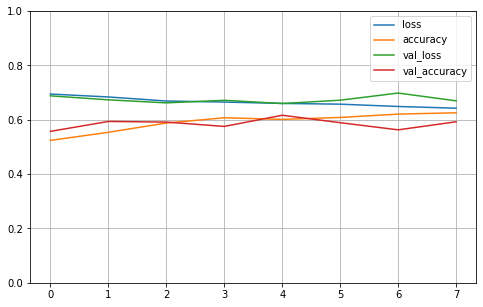


2023-03-26 20:18:15.905839

Testing # 1 5
2023-03-26 20:18:15.905940
2023-03-26 20:18:15.905977
PREDICT
2023-03-26 20:18:16.134198
Test 1:0 457:419 52.17%
Predict 1:0 520:356 59.36%
Test sizes (876, 4999) (876,)
Range of scores: 0.1055496 to 0.8089374
Score threshold 0.5
Confusion matrix
 [[209 210]
 [147 310]]
Normalized matrix
 [[0.23858447 0.23972603]
 [0.16780822 0.35388128]]


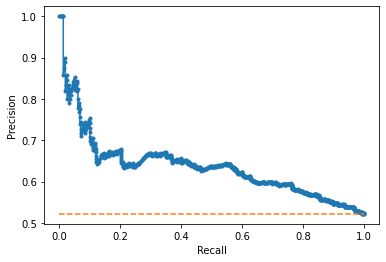

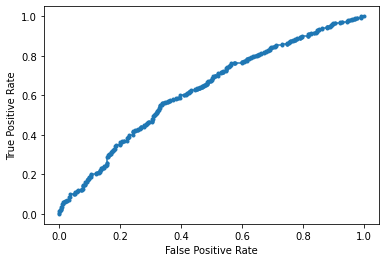

Accuracy: 59.25% Precision: 59.62% Recall: 67.83%
F1: 63.46% MCC: 0.1802
AUPRC: 63.63% AUROC: 62.79%
 accuracy [59.24657534246576]
 precision [59.61538461538461]
 recall [67.83369803063457]
 F1 [63.45957011258956]
 MCC [0.18016235962767374]
 AUPRC [63.633721109546435]
 AUROC [62.792519440368075]
2023-03-26 20:18:16.829311

Training # 2 1
2023-03-26 20:18:16.829443
2023-03-26 20:18:16.829492
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Computed class weights: {0: 1.0265330188679245, 1: 0.9748040313549832}
Valid 1:0 472:415 53.21%
FIT
2023-03-26 20:18:18.083482


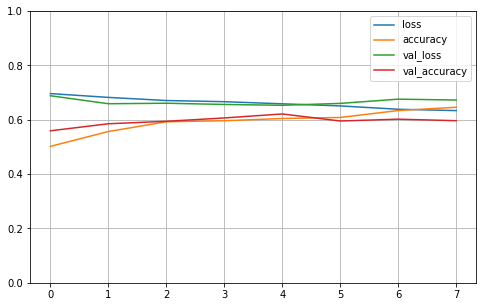


2023-03-26 20:18:39.964868

Testing # 2 1
2023-03-26 20:18:39.966253
2023-03-26 20:18:39.966651
PREDICT
2023-03-26 20:18:40.411325
Test 1:0 472:415 53.21%
Predict 1:0 666:221 75.08%
Test sizes (887, 4999) (887,)
Range of scores: 0.1307576 to 0.93715996
Score threshold 0.5
Confusion matrix
 [[139 276]
 [ 82 390]]
Normalized matrix
 [[0.156708   0.31116122]
 [0.09244645 0.43968433]]


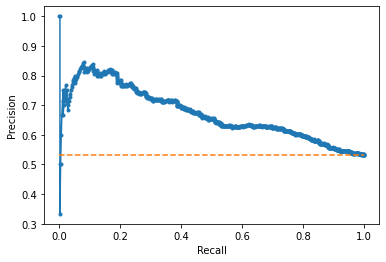

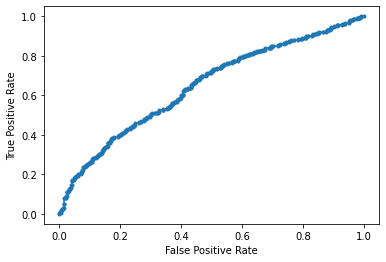

Accuracy: 59.64% Precision: 58.56% Recall: 82.63%
F1: 68.54% MCC: 0.1860
AUPRC: 67.13% AUROC: 64.80%
 accuracy [59.63923337091319]
 precision [58.55855855855856]
 recall [82.62711864406779]
 F1 [68.54130052724076]
 MCC [0.18597575107073536]
 AUPRC [67.12627029970217]
 AUROC [64.79936695936289]
2023-03-26 20:18:41.326051

Training # 2 2
2023-03-26 20:18:41.328595
2023-03-26 20:18:41.329075
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Computed class weights: {0: 1.0327433628318583, 1: 0.9692691029900332}
Valid 1:0 452:416 52.07%
FIT
2023-03-26 20:18:43.412983


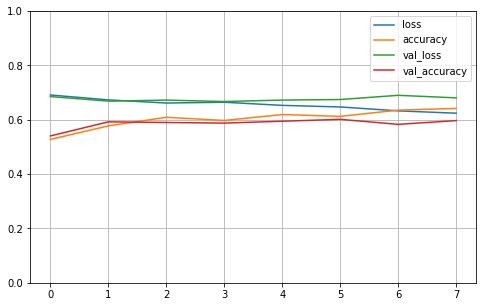


2023-03-26 20:19:05.216988

Testing # 2 2
2023-03-26 20:19:05.217292
2023-03-26 20:19:05.217337
PREDICT
2023-03-26 20:19:05.439093
Test 1:0 452:416 52.07%
Predict 1:0 410:458 47.24%
Test sizes (868, 4999) (868,)
Range of scores: 0.04038354 to 0.9135507
Score threshold 0.5
Confusion matrix
 [[262 154]
 [196 256]]
Normalized matrix
 [[0.30184332 0.17741935]
 [0.22580645 0.29493088]]


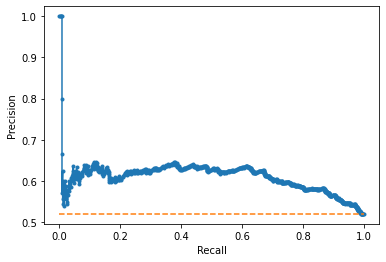

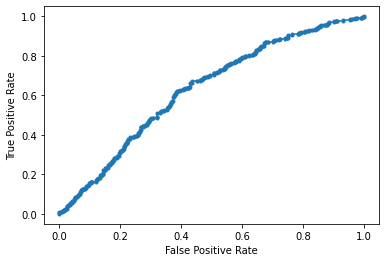

Accuracy: 59.68% Precision: 62.44% Recall: 56.64%
F1: 59.40% MCC: 0.1963
AUPRC: 61.12% AUROC: 63.11%
 accuracy [59.67741935483871]
 precision [62.4390243902439]
 recall [56.63716814159292]
 F1 [59.39675174013921]
 MCC [0.19631096555226935]
 AUPRC [61.1175599739761]
 AUROC [63.10521613342409]
2023-03-26 20:19:06.238868

Training # 2 3
2023-03-26 20:19:06.241934
2023-03-26 20:19:06.242319
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Computed class weights: {0: 1.0296361502347418, 1: 0.97202216066482}
Valid 1:0 453:407 52.67%
FIT
2023-03-26 20:19:08.236503


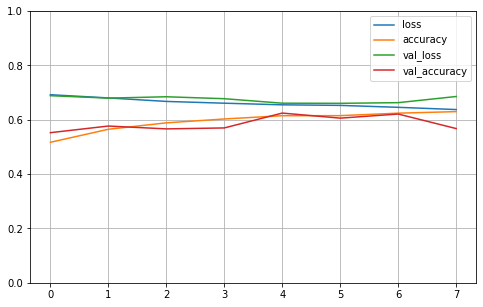


2023-03-26 20:19:31.065966

Testing # 2 3
2023-03-26 20:19:31.066288
2023-03-26 20:19:31.066327
PREDICT
2023-03-26 20:19:31.295008
Test 1:0 453:407 52.67%
Predict 1:0 291:569 33.84%
Test sizes (860, 4999) (860,)
Range of scores: 0.053913962 to 0.76219124
Score threshold 0.5
Confusion matrix
 [[302 105]
 [267 186]]
Normalized matrix
 [[0.35116279 0.12209302]
 [0.31046512 0.21627907]]


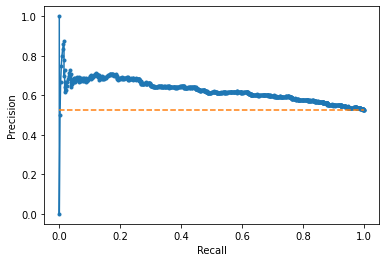

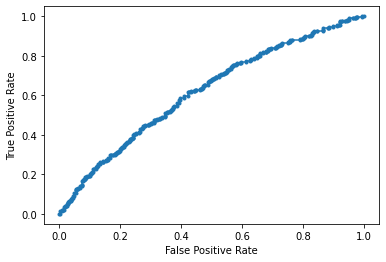

Accuracy: 56.74% Precision: 63.92% Recall: 41.06%
F1: 50.00% MCC: 0.1610
AUPRC: 62.42% AUROC: 61.95%
 accuracy [56.74418604651162]
 precision [63.91752577319587]
 recall [41.05960264900662]
 F1 [50.0]
 MCC [0.16103818133980158]
 AUPRC [62.423890364113696]
 AUROC [61.945208302824184]
2023-03-26 20:19:32.007779

Training # 2 4
2023-03-26 20:19:32.008724
2023-03-26 20:19:32.008773
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Computed class weights: {0: 1.0486778846153846, 1: 0.9556407447973713}
Valid 1:0 432:447 49.15%
FIT
2023-03-26 20:19:33.309012


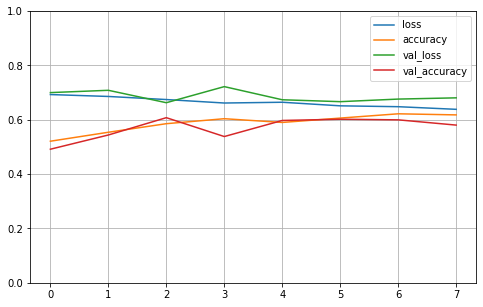


2023-03-26 20:19:48.714509

Testing # 2 4
2023-03-26 20:19:48.716085
2023-03-26 20:19:48.716486
PREDICT
2023-03-26 20:19:49.178425
Test 1:0 432:447 49.15%
Predict 1:0 285:594 32.42%
Test sizes (879, 4999) (879,)
Range of scores: 0.09733333 to 0.8825649
Score threshold 0.5
Confusion matrix
 [[336 111]
 [258 174]]
Normalized matrix
 [[0.38225256 0.12627986]
 [0.29351536 0.19795222]]


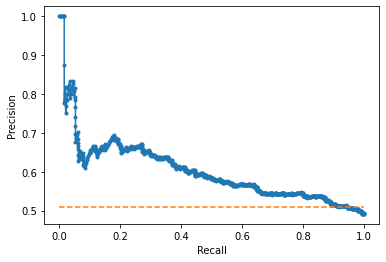

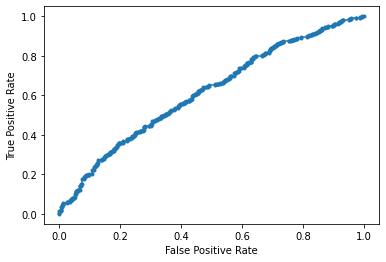

Accuracy: 58.02% Precision: 61.05% Recall: 40.28%
F1: 48.54% MCC: 0.1650
AUPRC: 60.23% AUROC: 61.60%
 accuracy [58.02047781569966]
 precision [61.05263157894737]
 recall [40.27777777777778]
 F1 [48.53556485355649]
 MCC [0.16496192885420022]
 AUPRC [60.231729307666384]
 AUROC [61.59530615626812]
2023-03-26 20:19:50.184440

Training # 2 5
2023-03-26 20:19:50.186257
2023-03-26 20:19:50.186670
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Computed class weights: {0: 1.0367952522255193, 1: 0.9657269209508016}
Valid 1:0 449:426 51.31%
FIT
2023-03-26 20:19:51.423739


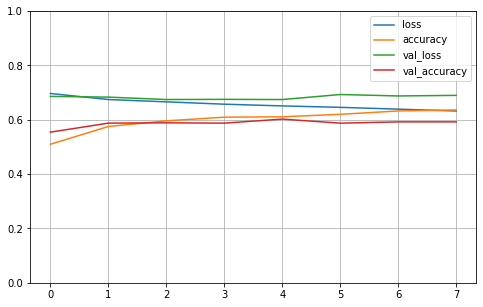


2023-03-26 20:20:13.235724

Testing # 2 5
2023-03-26 20:20:13.235836
2023-03-26 20:20:13.235874
PREDICT
2023-03-26 20:20:13.476218
Test 1:0 449:426 51.31%
Predict 1:0 532:343 60.80%
Test sizes (875, 4999) (875,)
Range of scores: 0.106690034 to 0.9534917
Score threshold 0.5
Confusion matrix
 [[206 220]
 [137 312]]
Normalized matrix
 [[0.23542857 0.25142857]
 [0.15657143 0.35657143]]


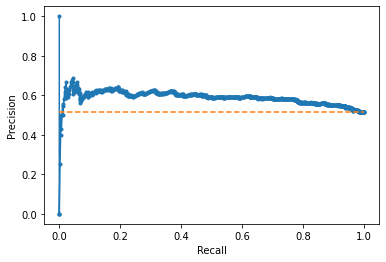

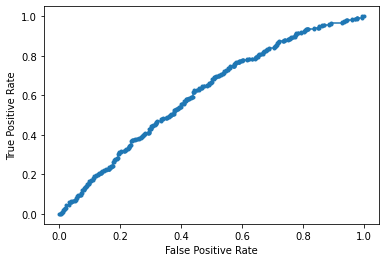

Accuracy: 59.20% Precision: 58.65% Recall: 69.49%
F1: 63.61% MCC: 0.1827
AUPRC: 58.86% AUROC: 61.16%
 accuracy [59.199999999999996]
 precision [58.64661654135338]
 recall [69.48775055679288]
 F1 [63.60856269113149]
 MCC [0.18269677902648804]
 AUPRC [58.86441395578468]
 AUROC [61.159383920449194]
2023-03-26 20:20:14.490579


In [23]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_sequence(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_sequence(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [24]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 58.26% std 1.42
 precision mean 59.41% std 3.08
 recall mean 64.57% std 16.22
 F1 mean 60.63% std 6.81
 MCC mean 0.17% std 0.03
 AUPRC mean 62.10% std 2.54
 AUROC mean 62.40% std 1.55
 accuracy [[59.310344827586206], [56.10859728506787], [56.18374558303887], [58.42696629213483], [59.24657534246576], [59.63923337091319], [59.67741935483871], [56.74418604651162], [58.02047781569966], [59.199999999999996]]
 precision [[62.38095238095238], [54.2319749216301], [57.056451612903224], [56.171983356449374], [59.61538461538461], [58.55855855855856], [62.4390243902439], [63.91752577319587], [61.05263157894737], [58.64661654135338]]
 recall [[57.20524017467249], [78.28054298642535], [64.02714932126696], [88.23529411764706], [67.83369803063457], [82.62711864406779], [56.63716814159292], [41.05960264900662], [40.27777777777778], [69.48775055679288]]
 F1 [[59.68109339407744], [64.07407407407408], [60.3411513859275], [68.64406779661016], [63.45957011258956], [68.54130052724076], [59.396